In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_data_path = "../data/train/"
test_data_path = "../data/test/"

In [3]:
transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485,0.456,0.406],
                        std = [0.229, 0.224, 0.225])
])

In [4]:
train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=transforms)
test_data = torchvision.datasets.ImageFolder(root=test_data_path, transform=transforms)

In [5]:
print("Num Images in Train Dataset:", len(train_data))
print("Num Images in Test Dataset:", len(test_data))

Num Images in Train Dataset: 3418
Num Images in Test Dataset: 373


In [6]:
batch_size=10
train_data_loader = data.DataLoader(train_data, batch_size=batch_size)
test_data_loader = data.DataLoader(test_data, batch_size=batch_size)

In [7]:
batch = next(iter(train_data_loader))

In [8]:
len(batch)

2

In [9]:
images, labels = batch

In [10]:
images.shape

torch.Size([10, 3, 64, 85])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


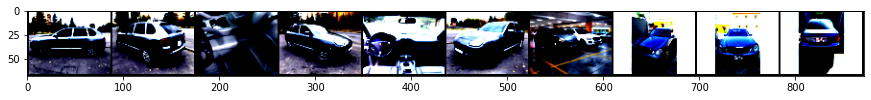

In [11]:
grid = torchvision.utils.make_grid(images, nrow=11)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)))
print("Labels:", labels)

In [12]:
grid.shape

torch.Size([3, 68, 872])

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*3*3, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=50)
        self.fc3 = nn.Linear(in_features=50, out_features=16)
    def forward(self, x):
        # (1) input layer
        x = x
        
        # (2) hidden conv layer
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        # (3) hidden conv layer
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        # (4) hidden linear layer
        x = x.reshape(-1, 12*3*3)
        x = self.fc1(x)
        x = F.relu(x)

        # (5) hidden linear layer
        x = self.fc2(x)
        x = F.relu(x)
        
        # (6) output layer
        x = self.fc3(x)
        # x = F.softmax(x, dim=1)
        return x
simplenet = Net()

In [14]:
sample = next(iter(train_data))

In [15]:
image,label = sample
image.shape

torch.Size([3, 64, 85])

In [16]:
image.unsqueeze(0).shape

torch.Size([1, 3, 64, 85])

In [17]:
pred = simplenet(image.unsqueeze(0))

c:\d\python\computer_vision_project\env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [18]:
pred.shape

torch.Size([26, 16])

In [19]:
pred.argmax(dim=1)

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6])

In [109]:
optimizer = optim.Adam(simplenet.parameters(), lr=0.001)

In [110]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [111]:
def train(model, device, train_loader, optimizer, epoch, steps_per_epoch=20):
  # Switch model to training mode. This is necessary for layers like dropout, batchnorm etc which behave differently in training and evaluation mode
  model.train()
  train_total = 0
  train_correct = 0

  # We loop over the data iterator, and feed the inputs to the network and adjust the weights.
  for batch_idx, (data, target) in enumerate(train_loader, start=0):
    if batch_idx > steps_per_epoch:
      break
    # Load the input features and labels from the training dataset
    data, target = data.to(device), target.to(device)
    
    # Reset the gradients to 0 for all learnable weight parameters
    optimizer.zero_grad()
    
    # Forward pass: Pass image data from training dataset, make predictions about class image belongs to (0-9 in this case)
    output = model(data)
    
    # Define our loss function, and compute the loss
    loss = F.nll_loss(output, target)

    scores, predictions = torch.max(output.data, 1)
    train_total += target.size(0)
    train_correct += int(sum(predictions == target))
            
    # Backward pass: compute the gradients of the loss w.r.t. the model's parameters
    loss.backward()
    
    # Update the neural network weights
    optimizer.step()

  acc = round((train_correct / train_total) * 100, 2)
  print('Epoch [{}], Loss: {}, Accuracy: {}'.format(epoch, loss.item(), acc), end='')
  wandb.log({'Train Loss': loss.item(), 'Train Accuracy': acc})

In [113]:
for epoch in range(10):
  train(simplenet, device, train_data_loader, optimizer, epoch)

ValueError: Expected input batch_size (260) to match target batch_size (10).